# Monday, April 28th

Last week, we setup code to run Conway's Game of Life and stored the history of cell configurations.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
def count_live_neighbors(cells,padded_cells,i,j):
    # Recall: The [i,j]th index of cells corresponds to
    # the [i+1, j+1]st index of padded_cells
    
    # We want a 3 by 3 grid centered at the [i,j]th cell of cells
    grid = padded_cells[i:i+3, j:j+3]

    # We can subtract cells[i,j] from the sum
    # to either remove a wrongly counted live neighbor
    # or do nothing if cells[i,j] is not alive
    live_neighbors = np.sum(grid) - cells[i,j]
    
    return live_neighbors

In [2]:
def update_cells(cells):
    new_cells = cells.copy()

    nrows, ncols = cells.shape
    padded_cells = np.zeros((nrows+2, ncols+2), dtype=int)
    padded_cells[1:-1, 1:-1] = cells
    for i in range(nrows):
        for j in range(ncols):
            # Get the number of live neighbors, excluding the cell itself
            live_neighbors = count_live_neighbors(cells, padded_cells, i, j)
            
            # If the is alive...
            if cells[i,j] == 1:
                # and if the cell has exactly 2 or 3 live neighbors...
                if live_neighbors == 2 or live_neighbors == 3:
                    # then the cell lives
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell dies
                    new_cells[i,j] = 0
            # If the cell is not alive...
            else:
                # and if it has exactly 3 live neighbors...
                if live_neighbors == 3:
                    # then the cell becomes alive
                    new_cells[i,j] = 1
                else:
                    # otherwise the cell remains dead
                    new_cells[i,j] = 0
    return new_cells

In [3]:
def random_state(n, ratio_live_cells):
    cells = np.zeros((n,n))

    live_cell_mask = np.random.random((n,n)) < ratio_live_cells
    cells[live_cell_mask] = 1
    
    return cells

In [7]:
T = 200    # Set the number of time steps
n = 100   # Set the grid size, i.e. n x n

cells = random_state(n, .1)        # Initialize the starting configuration
cells_history = np.zeros((n,n,T))  # Initialize the array containing all configurations
cells_history[:,:,0] = cells       # Set the t=0 slice to match the initial configuarion

for t in range(1,T):
    cells = update_cells(cells)    # Update the `cells` array
    cells_history[:,:,t] = cells   # store the update cells array in slice t

In [8]:
# Count the number of live cells at each time slice
number_of_live_cells = np.sum(cells_history == 1, axis=(0,1))

Text(0, 0.5, 'Number of live cells')

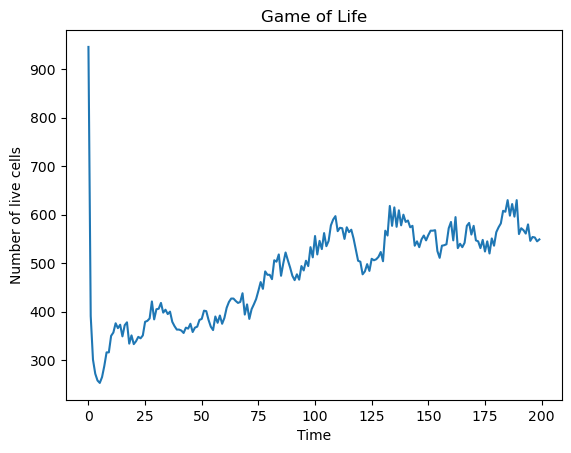

In [9]:
t_list = np.arange(T)

plt.plot(t_list, number_of_live_cells, '-')

plt.title('Game of Life')
plt.xlabel('Time')
plt.ylabel('Number of live cells')

Note: Our initial condition is a random configuration of live cells, where we are controlling the percentage of live cells. It would be useful to make some visualization that accounts for this randomness, rather than relying any one particular run.